In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import (rc_context, rcParams, patches, 
            patheffects as path_effects)
import sunpy
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u
from astropy.visualization import ImageNormalize, AsinhStretch
from astropy.time import Time
from glob import glob
from watroo import wow
from fancy_colorbar import plot_colorbar
from sjireader import read_iris_sji
from copy import deepcopy

In [2]:
ms_style_dict = {'text.usetex': True, 'font.family': 'serif', 'axes.linewidth': 1.2,
                 'xtick.major.width': 1.2, 'xtick.major.size': 4,
                 'ytick.major.width': 1.2, 'ytick.major.size': 4,
                 'xtick.minor.width': 1.2, 'xtick.minor.size': 2,
                 'ytick.minor.width': 1.2, 'ytick.minor.size': 2,
                 'xtick.direction': 'in', 'ytick.direction': 'in',
                 'text.latex.preamble': r'\usepackage[T1]{fontenc}'
                 r'\usepackage{amsmath}' r'\usepackage{siunitx}'
                 r'\sisetup{detect-all=True}'}
rcParams.update(ms_style_dict)

In [3]:
hri_maps_1020 = sorted(glob('../../src/EUI/HRI/euv174/20221020/coalign_step_boxcar/*.fits'))
hri_map_1020 = sunpy.map.Map(hri_maps_1020[195])
Txshift_hri_1020, Tyshift_hri_1020 = (9.41462 - 20.8515)*u.arcsec, (7.05089-8.29747)*u.arcsec
hri_map_1020 = hri_map_1020.shift_reference_coord(Txshift_hri_1020, Tyshift_hri_1020)

In [4]:
hri_map_1020_wow = sunpy.map.Map(wow(hri_map_1020.data, bilateral=1, denoise_coefficients=[5,3])[0], 
                                 hri_map_1020.meta)
hri_map_1020_wow_zoomin = hri_map_1020_wow.submap([1800,350]*u.pix, top_right=[2047,650]*u.pix)

In [5]:
def reproject_to_above_surface(map,target_wcs,radius=None,height=None):
    if radius is None and height is not None:
        rsun_ref = map.meta["rsun_ref"] + height.to_value(u.m)
    elif radius is not None and height is None:
        rsun_ref = radius.to_value(u.m)
    else:
        rsun_ref = map.meta["rsun_ref"]

    map_new = deepcopy(map)
    target_wcs_new = deepcopy(target_wcs)

    map_new.meta["rsun_ref"] = rsun_ref
    target_wcs_new.wcs.aux.rsun_ref = rsun_ref

    return map_new.reproject_to(target_wcs_new)

In [6]:
eis_195_velmap_derot = sunpy.map.Map('../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_velmap_shift.fits')
eis_195_velmap_derot.meta['rsun_ref'] = 696000000 + 2.8e6
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_195_velmap_derot_repro_hrifov = reproject_to_above_surface(eis_195_velmap_derot, hri_map_1020_wow.wcs, height=2.8*u.Mm)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


In [7]:
hri_map_1020_wow_data = hri_map_1020_wow.data.copy()
hri_map_1020_wow_data_indices_y, hri_map_1020_wow_data_indices_x = np.indices(hri_map_1020_wow_data.shape)
hri_map_1020_colorful_mask = (hri_map_1020_wow_data_indices_y >= 350) & (hri_map_1020_wow_data_indices_y <= 650) \
                                      & (hri_map_1020_wow_data_indices_x <= 2047) & (hri_map_1020_wow_data_indices_x >= 1800)
hri_map_1020_wow_data[~hri_map_1020_colorful_mask] = np.nan
hri_map_1020_wow_colorful = plt.get_cmap('sdoaia171')(ImageNormalize()(hri_map_1020_wow_data))

In [8]:
hri_map_1020_wow_zoomin_edges = sunpy.map.map_edges(hri_map_1020_wow_zoomin)
# hri_map_1024_wow_zoomin_region_1_edges = sunpy.map.map_edges(hri_map_1024_wow_zoomin_region_1)
# hri_map_1024_wow_zoomin_region_2_edges = sunpy.map.map_edges(hri_map_1024_wow_zoomin_region_2)

In [9]:
hri_map_1020_west_array = np.load('../../sav/optical_flow/eui_map_crop_array_1800_0350_2048_0650_1020.npz')['eui_map_seq_crop_array']
hri_map_1020_zoomin_std = np.nanstd(hri_map_1020_west_array[:,:,:],axis=2)/np.nanmean(hri_map_1020_west_array[:,:,:],axis=2)
hri_map_1020_zoomin_std_map = sunpy.map.Map(hri_map_1020_zoomin_std, hri_map_1020_wow_zoomin.meta)

In [10]:
hri_maps_1026 = sorted(glob('../../src/EUI/HRI/euv174/20221026/coalign_step_boxcar/*.fits'))
hri_map_1026 = sunpy.map.Map(hri_maps_1026[181])
Txshift_hri_1026, Tyshift_hri_1026 = (-0.0235313 - 6.3736)*u.arcsec, (7.82867 - 0.685765)*u.arcsec
hri_map_1026 = hri_map_1026.shift_reference_coord(Txshift_hri_1026, Tyshift_hri_1026)
hri_map_1026 = hri_map_1026.submap([150,150]*u.pix, top_right=[2047,2047]*u.pix)

In [11]:
hri_map_1026_wow = sunpy.map.Map(wow(hri_map_1026.data, bilateral=1, denoise_coefficients=[5,3])[0], 
                                 hri_map_1026.meta)
hri_map_1026_wow_zoomin = hri_map_1026_wow.submap([1600,300]*u.pix, top_right=[1800,550]*u.pix)

In [12]:
hri_map_1026_wow_data = hri_map_1026_wow.data.copy()
hri_map_1026_wow_data_indices_y, hri_map_1026_wow_data_indices_x = np.indices(hri_map_1026_wow_data.shape)
hri_map_1026_colorful_mask = (hri_map_1026_wow_data_indices_y >= 300) & (hri_map_1026_wow_data_indices_y <= 550) \
                                        & (hri_map_1026_wow_data_indices_x <= 1800) & (hri_map_1026_wow_data_indices_x >= 1600)
hri_map_1026_wow_data[~hri_map_1026_colorful_mask] = np.nan
hri_map_1026_wow_colorful = plt.get_cmap('sdoaia171')(ImageNormalize()(hri_map_1026_wow_data))

In [13]:
hri_map_1026_wow_zoomin_edges = sunpy.map.map_edges(hri_map_1026_wow_zoomin)

In [14]:
iris_sji_1400_map = read_iris_sji('../../src/IRIS/20221020/1905/iris_l2_20221020_190518_3640007428_SJI_1400_t000.fits', 
                                  index=Time(hri_map_1020.meta['date_ear'])).rotate()
iris_sji_2796_map = read_iris_sji('../../src/IRIS/20221020/1905/iris_l2_20221020_190518_3640007428_SJI_2796_t000_deconvolved.fits',
                                  index=Time(hri_map_1020.meta['date_ear'])).rotate()

In [15]:
iris_sji_1400_map_zoomin = iris_sji_1400_map.submap(SkyCoord(-900*u.arcsec, 180*u.arcsec, frame=iris_sji_1400_map.coordinate_frame),
                                                    top_right=SkyCoord(-825*u.arcsec, 300*u.arcsec, frame=iris_sji_1400_map.coordinate_frame))
iris_sji_2796_map_zoomin = iris_sji_2796_map.submap(SkyCoord(-900*u.arcsec, 180*u.arcsec, frame=iris_sji_2796_map.coordinate_frame),
                                                    top_right=SkyCoord(-825*u.arcsec, 300*u.arcsec, frame=iris_sji_2796_map.coordinate_frame))

iris_sji_1400_map_zoomin_wow = sunpy.map.Map(wow(iris_sji_1400_map_zoomin.data, bilateral=1, denoise_coefficients=[5,3])[0], 
                                            iris_sji_1400_map_zoomin.meta)
iris_sji_2796_map_zoomin_wow = sunpy.map.Map(wow(iris_sji_2796_map_zoomin.data, bilateral=1, denoise_coefficients=[2,1])[0],
                                            iris_sji_2796_map_zoomin.meta)

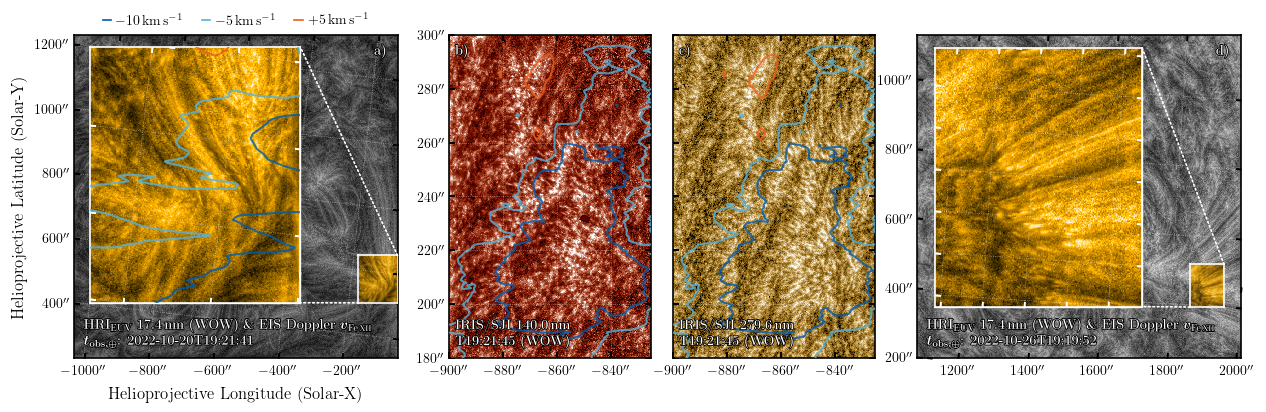

In [19]:
fig = plt.figure(figsize=(12.5, 4),layout='constrained')

gs1 = fig.add_gridspec(nrows=1, ncols=4, wspace=0, hspace=0,width_ratios=[2,2/np.divide(*iris_sji_1400_map_zoomin.data.shape),
                                                                          2/np.divide(*iris_sji_1400_map_zoomin.data.shape),2])
ax1 = fig.add_subplot(gs1[:,0], projection=hri_map_1020)

hri_map_1020_wow.plot(norm=ImageNormalize(),cmap='grey',title=False,
                      axes=ax1)

ax1.imshow(hri_map_1020_wow_colorful, origin='lower', alpha=0.9)

ax1_zoomin = ax1.inset_axes([0.05,340/2048,0.65,0.8], projection=hri_map_1020_wow_zoomin,
                            transform=ax1.transAxes)

hri_map_1020_wow_zoomin.plot(norm=ImageNormalize(),title=False,axes=ax1_zoomin,cmap='sdoaia171')

ax1_zoomin_bounds = ax1_zoomin.axis()
cs = eis_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],
                                                     alpha=0.8,axes=ax1_zoomin)
legend_artist = [plt.Line2D([0],[0], color="#005CAF", lw=1.2),
                 plt.Line2D([0],[0], color="#58B2DC", lw=1.2),
                 plt.Line2D([0],[0], color="#F05E1C", lw=1.2),]
legend_labels = [r'$-10\,\mathrm{km\,s^{-1}}$',r'$-5\,\mathrm{km\,s^{-1}}$',r'$+5\,\mathrm{km\,s^{-1}}$']
ax1.legend(legend_artist,legend_labels,bbox_to_anchor=(0.05, 1.0, 0.9, 0.1), frameon=False,fontsize=10,
           mode='expand', ncol=3, handlelength=0.6,handletextpad=0.4)

ax1_zoomin.axis(ax1_zoomin_bounds)

for edge in hri_map_1020_wow_zoomin_edges:
    edge_x, edge_y = edge.T.to_value(u.pix)
    ax1.plot(edge_x + 1800, edge_y + 350, lw=1.2, color='white')

connect_patch_0 = patches.ConnectionPatch(xyA=(1800, 350), xyB=(1,0),
        coordsA="data", coordsB="axes fraction",axesA=ax1, axesB=ax1_zoomin, color="white",
        zorder=2,lw=1.2,ls=':')

connect_patch_1 = patches.ConnectionPatch(xyA=(2047, 650), xyB=(1,1),
        coordsA="data", coordsB="axes fraction",axesA=ax1, axesB=ax1_zoomin, color="white",
        zorder=2,lw=1.2,ls=':')

for patch_ in (connect_patch_0, connect_patch_1,):
    fig.add_artist(patch_)

ax1_zoomin.coords[0].set_ticklabel_visible(False)
ax1_zoomin.coords[1].set_ticklabel_visible(False)
ax1_zoomin.coords[0].set_ticks(color='white')
ax1_zoomin.coords[1].set_ticks(color='white')
ax1_zoomin.coords[0].frame._color = 'white'

ax1.text(0.03,0.03,r'\textbf{HRI\textsubscript{EUV} 17.4\,nm (WOW)} '
         r'\textbf{\& EIS Doppler} $\boldsymbol{v}_{\textbf{Fe\,\textsc{xii}}}$' + '\n'
         r'$\boldsymbol{{t_{{\mathrm{{obs}},\oplus}}}}$\textbf{{: {}}}'.format(hri_map_1020_wow.meta['date_ear'][:-4]),
         fontsize=10,transform=ax1.transAxes,va='bottom',ha='left',color='white', linespacing=1.3,
         path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),path_effects.Normal()])

ax1.text(0.97,0.97,r'\textbf{a)}',fontsize=10,transform=ax1.transAxes,va='top',ha='right',color='white',
         path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),path_effects.Normal()])

ax1.set_xlabel(r"Helioprojective Longitude (Solar-X)", fontsize=12)
ax1.set_ylabel(r"Helioprojective Latitude (Solar-Y)", fontsize=12)

# ax2 = fig.add_subplot(gs1[:,1], projection=hri_map_1020_zoomin_std_map)
# im2 = hri_map_1020_zoomin_std_map.plot(norm=ImageNormalize(vmin=np.nanpercentile(hri_map_1020_zoomin_std_map.data,1),
#                                                            vmax=np.nanpercentile(hri_map_1020_zoomin_std_map.data,99)),cmap='inferno',title=False,axes=ax2)

# clb2, clb_ax2 = plot_colorbar(im2, ax2,
#                                     bbox_to_anchor=(0.05,1.04,0.9,0.04), orientation='horizontal',
#                                     fontsize=10,scilimits=(-2,2))
# clb_ax2.xaxis.tick_top()
# clb_ax2.xaxis.set_label_position('top') 

# ax2.text(0.03,0.97,r'\textbf{b)}',fontsize=10,transform=ax2.transAxes,va='top',ha='left',color='white',
#             path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),path_effects.Normal()])

# ax2.text(0.03,0.03,r'\textbf{HRI\textsubscript{EUV}} $\boldsymbol{\sigma/\mu}$',fontsize=10,
#          transform=ax2.transAxes,va='bottom',ha='left',color='white',
#          path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),path_effects.Normal()])

ax2 = fig.add_subplot(gs1[:,1],projection=iris_sji_1400_map_zoomin_wow)
im2 = iris_sji_1400_map_zoomin_wow.plot(title=False,axes=ax2, 
                                                 norm=ImageNormalize(vmin=np.nanpercentile(iris_sji_1400_map_zoomin_wow.data, 1),
                                                               vmax=np.nanpercentile(iris_sji_1400_map_zoomin_wow.data, 99.5)))

ax2.text(0.03,0.97,r'\textbf{b)}',fontsize=10,transform=ax2.transAxes,va='top',ha='left',color='white',
            path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),path_effects.Normal()])

ax2.text(0.03,0.03,r'\textbf{IRIS/SJI 140.0\,nm}' + \
            '\n' + r'\textbf{{{} (WOW)}}'.format(iris_sji_1400_map_zoomin_wow.date.isot[10:-4]),fontsize=10,
            transform=ax2.transAxes,va='bottom',ha='left',color='white',
            path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),path_effects.Normal()])

ax3 = fig.add_subplot(gs1[:,2],projection=iris_sji_2796_map_zoomin_wow)
im3 = iris_sji_2796_map_zoomin_wow.plot(title=False,axes=ax3,
                                                 norm=ImageNormalize(vmin=np.nanpercentile(iris_sji_2796_map_zoomin_wow.data, 1),
                                                   vmax=np.nanpercentile(iris_sji_2796_map_zoomin_wow.data, 99.8)),)

ax3.text(0.03,0.97,r'\textbf{c)}',fontsize=10,transform=ax3.transAxes,va='top',ha='left',color='white',
            path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),path_effects.Normal()])

ax3.text(0.03,0.03,r'\textbf{IRIS/SJI 279.6\,nm}' + \
            '\n' + r'\textbf{{{} (WOW)}}'.format(iris_sji_2796_map_zoomin_wow.date.isot[10:-4]),fontsize=10,
            transform=ax3.transAxes,va='bottom',ha='left',color='white',
            path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),path_effects.Normal()])

ax4 = fig.add_subplot(gs1[:,3], projection=hri_map_1026_wow)
im4 = hri_map_1026_wow.plot(norm=ImageNormalize(),cmap='grey',title=False,axes=ax4)

ax4.imshow(hri_map_1026_wow_colorful, origin='lower', alpha=0.9)

ax4_zoomin = ax4.inset_axes([0.05,295/1848,0.65,0.8], projection=hri_map_1026_wow_zoomin,
                            transform=ax4.transAxes)

hri_map_1026_wow_zoomin.plot(norm=ImageNormalize(),title=False,axes=ax4_zoomin,cmap='sdoaia171')

ax4_zoomin_bounds = ax4_zoomin.axis()
for edge in hri_map_1026_wow_zoomin_edges:
    edge_x, edge_y = edge.T.to_value(u.pix)
    ax4.plot(edge_x + 1600, edge_y + 300, lw=1.2, color='white')

connect_patch_2 = patches.ConnectionPatch(xyA=(1600, 300), xyB=(1,0),
        coordsA="data", coordsB="axes fraction",axesA=ax4, axesB=ax4_zoomin, color="white",
        zorder=2,lw=1.2,ls=':')

connect_patch_3 = patches.ConnectionPatch(xyA=(1800, 550), xyB=(1,1),
        coordsA="data", coordsB="axes fraction",axesA=ax4, axesB=ax4_zoomin, color="white",
        zorder=2,lw=1.2,ls=':')

for patch_ in (connect_patch_2, connect_patch_3,):
    fig.add_artist(patch_)

ax4_zoomin.coords[0].set_ticklabel_visible(False)
ax4_zoomin.coords[1].set_ticklabel_visible(False)
ax4_zoomin.coords[0].set_ticks(color='white')
ax4_zoomin.coords[1].set_ticks(color='white')
ax4_zoomin.coords[0].frame._color = 'white'

ax4.text(0.03,0.03,r'\textbf{HRI\textsubscript{EUV} 17.4\,nm (WOW)} '
            r'\textbf{\& EIS Doppler} $\boldsymbol{v}_{\textbf{Fe\,\textsc{xii}}}$' + '\n'
            r'$\boldsymbol{{t_{{\mathrm{{obs}},\oplus}}}}$\textbf{{: {}}}'.format(hri_map_1026_wow.meta['date_ear'][:-4]),
            fontsize=10,transform=ax4.transAxes,va='bottom',ha='left',color='white', linespacing=1.3,
            path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),path_effects.Normal()])

ax4.text(0.97,0.97,r'\textbf{d)}',fontsize=10,transform=ax4.transAxes,va='top',ha='right',color='white',
            path_effects=[path_effects.Stroke(linewidth=1.2, foreground='black'),path_effects.Normal()])


for ax_ in (ax2,ax3):
    with propagate_with_solar_surface(rotation_model='rigid'):
        ax_bounds = ax_.axis()
        cs = eis_195_velmap_derot.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],
                                                            alpha=0.8,axes=ax_)
        ax_.axis(ax_bounds)

for ax_ in (ax2,ax3,ax4):
    ax_.coords[0].axislabels.set_visible(False)
    ax_.coords[1].axislabels.set_visible(False)

ax3.coords[1].set_ticklabel_visible(False)
fig.get_layout_engine().set(w_pad=1/72., h_pad=1/72., hspace=0,
                        wspace=0.02)

plt.savefig('../../figs/ms_eis_eui_upflow/hri_west_upflow.pdf',dpi=300,bbox_inches='tight')